In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [35]:
def sample_batch(batch_size, device='cpu'):
    data, _ = make_swiss_roll(batch_size)
    data = data[:, [2, 0]] / 10
    data = data * np.array([1, -1])
    return torch.from_numpy(data).to(device)

In [36]:
class DiffusionModel():
    
    def __init__(self, T, model: nn.Module):
        
        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        
        self.T = T
        self.model = model
        
    def forward_process(self, x0, t): 
        """
        :param t: Number of diffusion steps
        """
        
        assert t > 0, 't should be greater than 0'
        assert T <= self.T, f't should be lower or equal than {self.T}'
        
        t = t -1 # Because we start indexing at 0
        
        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        
        return mu + epsilon * std # data ~ N(mu, std)
    
    def reverse_process(self, xt, t): 
        """
        :param t: Number of diffusion steps
        """
        
        assert t > 0, 't should be greater than 0'
        assert T <= self.T, f't should be lower or equal than {self.T}'
        
        t = t - 1 # Because we start indexing at 0
        
        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(x0)
        
        return mu + epsilon * std # data ~ N(mu, std)
        
        

In [54]:
x0 = sample_batch(3_000)
model = DiffusionModel(40)
xT = model.forward_process(x0, 20)

In [55]:
print(xT.mean(0))
print(xT.std(0))

tensor([ 0.0143, -0.2046], dtype=torch.float64)
tensor([0.6932, 0.6639], dtype=torch.float64)


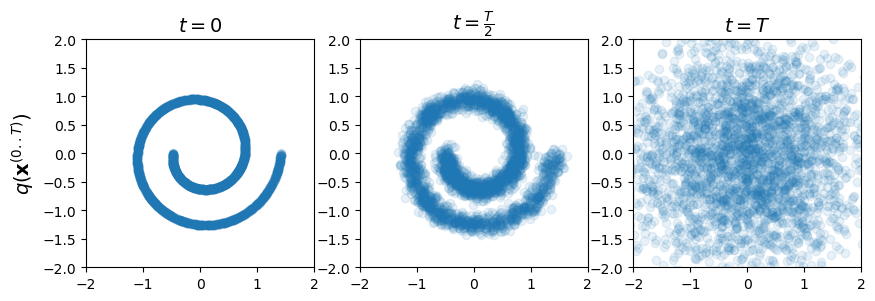

In [66]:
fontsize = 14
fig = plt.figure(figsize=(10, 3))

data = [x0, model.forward_process(x0, 20), model.forward_process(x0, 40)]
for i in range(3):
    
    plt.subplot(1, 3, 1+i)
    plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha=0.1)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.gca().set_aspect('equal')
    
    if i == 0: plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize=fontsize)
    if i == 0: plt.title(r'$t=0$', fontsize=fontsize)
    if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=fontsize)
    if i == 2: plt.title(r'$t=T$', fontsize=fontsize)
plt.savefig('forward_process.png', bbox_inches='tight')